In [1]:
%matplotlib inline
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch
#from pyviz_med.visual import PyPatient

# MRE data exploration

Check the contents of the data root directory.

In [2]:
data_dir = '/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI'
%ls $data_dir

 0006/   0029/   0123/   0175/   0362/   0450/   2033/       'CASE 2^2'/
 001/    0041/   0126/   0189/   0378/   1753/   2036/
 0014/   0043/   0135/   0199/   0384/   2007/   2040/
 0015/   0047/   0155/   0213/   0395/   2012/   2050/
 0020/   0079/   0164/   0291/   0401/   2013/   2052/
 0021/   0084/   0167/   0314/   0415/   2015/   2053/
 0024/   0094/   0172/   0332/   0424/   2029/   2060/
 0026/   0096/   0173/   0344/   0435/   2032/  'CASE 1^1'/


Check the contents of a subject directory.

In [3]:
subject_id = '0006'
subject_dir = f'{data_dir}/{subject_id}'
%ls $subject_dir

MRE_DICOM_7-31-19_DICOMD_PA0*  t1_pos_0_out.nii*      t1_pos_70_out.nii*
dwi.nii*                       t1_pos_0_water.nii*    t1_pos_70_water.nii*
mre.nii*                       t1_pos_160_fat.nii*    t1_pre_fat.nii*
mre.pkl*                       t1_pos_160_in.nii*     t1_pre_in.nii*
mre_mask.nii*                  t1_pos_160_out.nii*    t1_pre_out.nii*
mre_phase.nii*                 t1_pos_160_water.nii*  t1_pre_water.nii*
mre_raw.nii*                   t1_pos_300_fat.nii*    t2.nii*
mre_wave.nii*                  t1_pos_300_water.nii*  wave.nii*
t1_pos_0_fat.nii*              t1_pos_70_fat.nii*
t1_pos_0_in.nii*               t1_pos_70_in.nii*


In [4]:
def myshow(img, dpi=40, margin=0.1, arr=None, verbose=True):
    
    # convert SITK image to numpy array
    if arr is None:
        arr = sitk.GetArrayViewFromImage(img)

    # get spacing of image pixels
    spacing = img.GetSpacing()[::-1]

    basis = np.reshape(img.GetDirection(), (3,3))
    
    if verbose:
        print(f'dtype = {arr.dtype}')
        print(f'shape = {arr.shape}')
        print(f'spacing = {spacing}')
        print(f'basis = \n{basis}')
    
    # must be 2D or 3D; grayscale, RGB, or RGBA
    assert arr.ndim in {2, 3, 4}, arr.ndim
    
    # last dimension determines if RGB/RGBA
    rgb = arr.shape[-1] in {3, 4} # RGB or RGBA
    
    # promote to 3D for plotting purposes
    if arr.shape == 2 or (arr.shape == 3 and rgb):
        array = arr[np.newaxis,...]
        spacing = arr[np.newaxis,...]
    
    # set spatial extent of image
    z_shape, y_shape, x_shape = arr.shape[:3]
    z_space, y_space, x_space = spacing
    extent = [0, x_shape*x_space, 0, y_shape*y_space]
    
    # plot z slices as subplots
    n_rows, n_cols = 1, arr.shape[0] #arr.shape[0], 1
    ax_h = (1 + margin) * y_shape / dpi
    ax_w = (1 + margin) * x_shape / dpi
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(ax_w*n_cols, ax_h*n_rows))
    plt.subplots_adjust(hspace=margin, wspace=margin)
    
    for i, a in enumerate(arr):
        axes[i].imshow(a, extent=extent, cmap=None if rgb else plt.cm.Greys_r)
        axes[i].axis('off')


dtype = int16
shape = (4, 256, 256)
spacing = (1.0, 1.4062999486923218, 1.4062999486923218)
basis = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


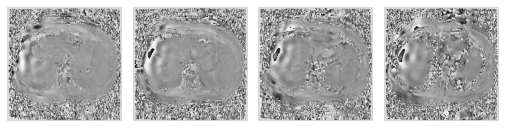

In [135]:
img_name = 'mre_phase'
img = sitk.ReadImage(f'{data_dir}/{subject_id}/{img_name}.nii')
myshow(img, dpi=128)

dtype = uint8
shape = (4, 512, 512, 3)
spacing = (1.0, 1.0, 1.0)
basis = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


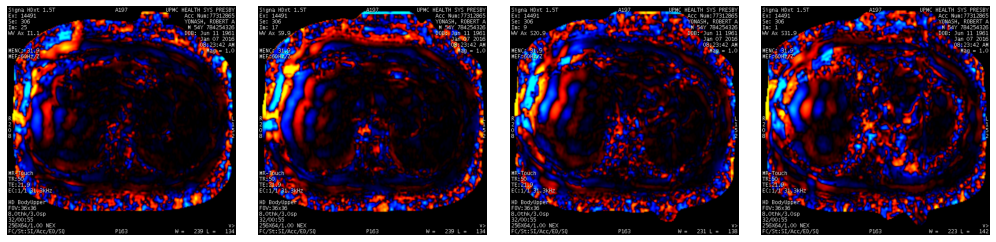

In [138]:
img_name = 'wave'
img = sitk.ReadImage(f'{data_dir}/{subject_id}/{img_name}.nii')
myshow(img, dpi=128)

(4, 512, 512, 3)

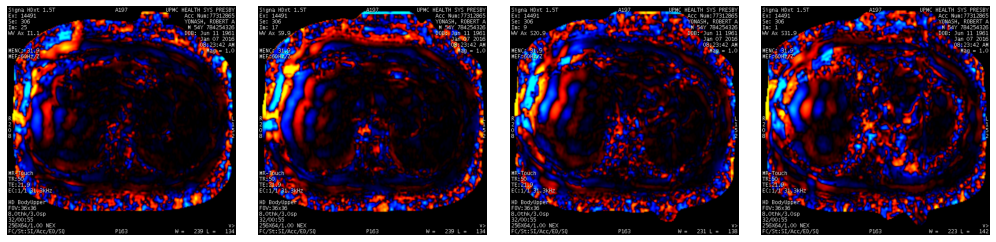

In [116]:
scale = 1
arr = sitk.GetArrayViewFromImage(img)[:,::scale,::scale,:]
myshow(img, dpi=128/scale, arr=arr, verbose=False)
arr.shape

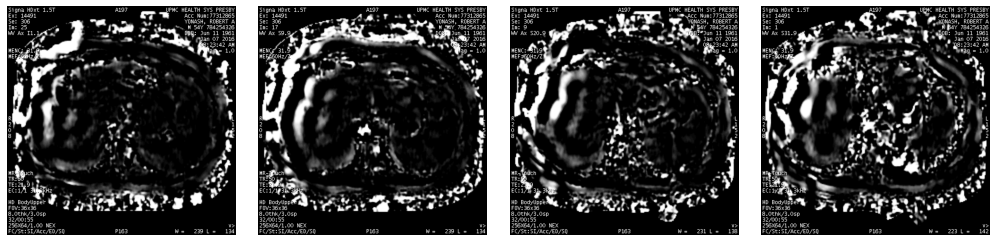

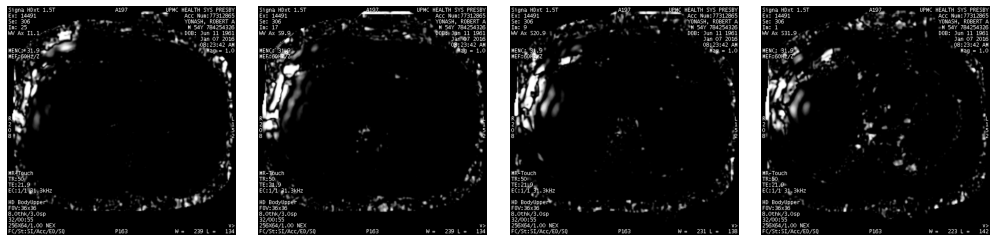

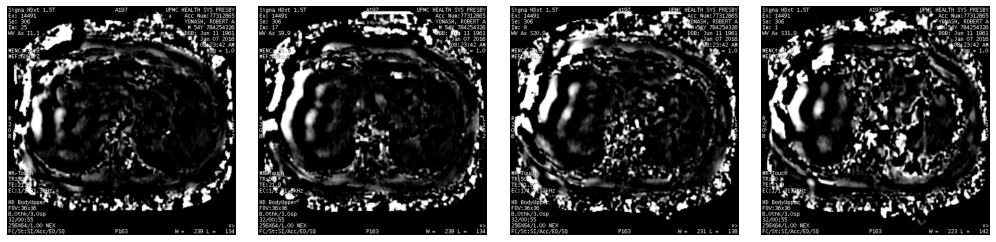

In [117]:
arr_r = arr[:,:,:,0]
arr_g = arr[:,:,:,1]
arr_b = arr[:,:,:,2]
myshow(img, dpi=128//scale, arr=arr_r, verbose=False)
myshow(img, dpi=128//scale, arr=arr_g, verbose=False)
myshow(img, dpi=128//scale, arr=arr_b, verbose=False)

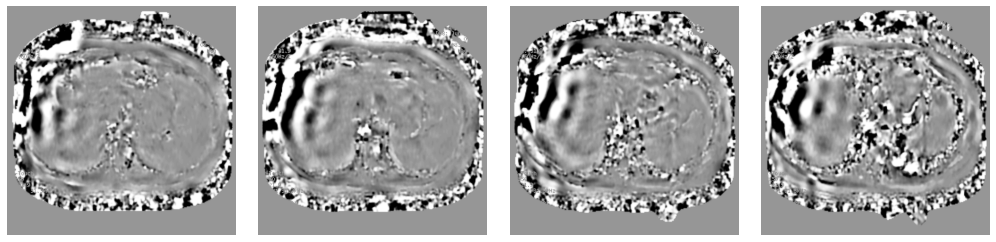

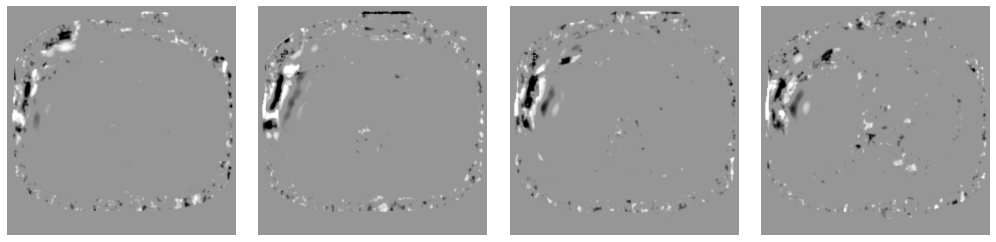

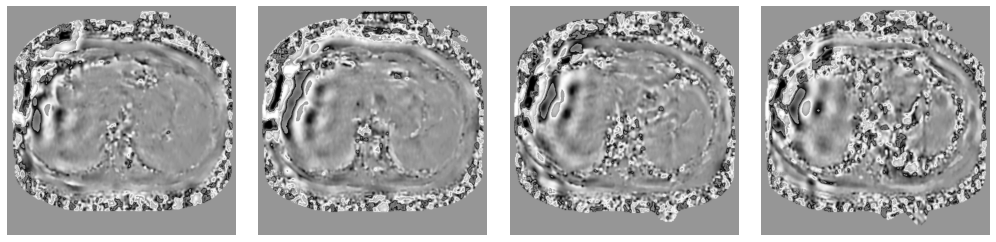

In [118]:
# turn red into positive values
# turn blue into negative values

arr_mod = 0.001*(arr_r) - 0.001*(arr_b)
myshow(img, dpi=128/scale, arr=arr_mod, verbose=False)
arr_pre = arr_mod

arr_gr = np.where(arr_r == 0, 0, arr_g) # green where red is nonzero
arr_gb = np.where(arr_b == 0, 0, arr_g) # green where blue is nonzero

# show just the green wave components
arr_mod = 0.001*(arr_gr) - 0.001*(arr_gb)
myshow(img, dpi=128/scale, arr=arr_mod, verbose=False)

# so this is how I think this works
# red vs blue indicates the sign of the wave 
# green indicates especially high amplitude (how high?)
# so when red wave is very high, it becomes yellow
# when blue wave is very high, it becomes cyan
# assuming a linear relation, all we are doing here
# is adding the green component to blue/red component
# but only in the channel with high amplitude
# and then we are shifting/scaling so that
# red is positive, blue is negative, and we deal with floats
# visually, the ones where just just omit the green channel
# look better/less noisy to me
# but we might be creating a max value threshold by doing so...
arr_mod = 0.001*(arr_r + arr_gr) - 0.001*(arr_b + arr_gb)
myshow(img, dpi=128/scale, arr=arr_mod, verbose=False)

KeyboardInterrupt: 

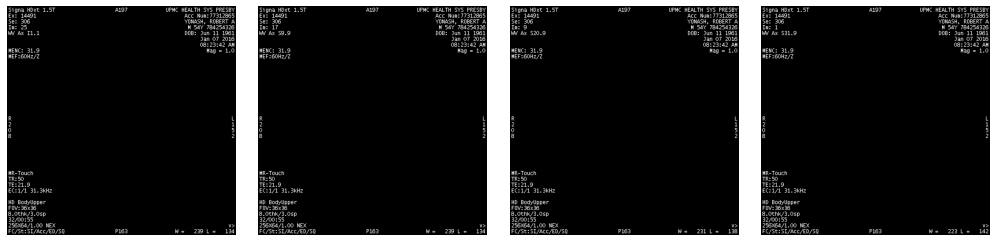

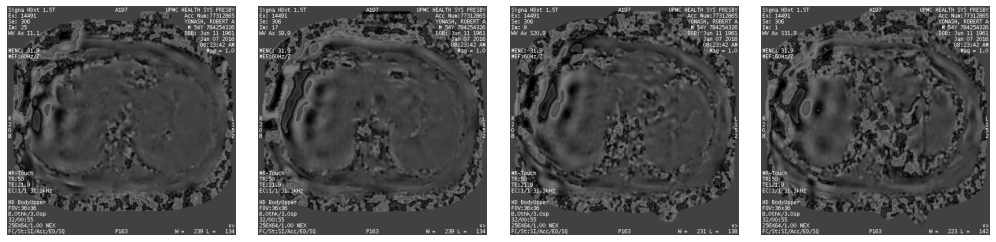

In [119]:
arr_txt = np.where((arr_r == 255) & (arr_g == 255) & (arr_b == 255), 1, 0)

myshow(img, dpi=128/scale, arr=arr_txt, verbose=False)

arr_txt = arr_txt + arr_mod

myshow(img, dpi=128/scale, arr=arr_txt, verbose=False)

from skimage.morphology import binary_dilation
from skimage.restoration import inpaint

# create an array with a text mask, expand the mask, and do inpainting
n_dilate = 2
array = np.ma.masked_where(arr_txt == 1, arr_txt)
for i in range(arr_txt.shape[0]):
    for j in range(n_dilate):
        array[i].mask = binary_dilation(array[i].mask)
    arr_txt[i] = inpaint.inpaint_biharmonic(arr_txt[i], array[i].mask)
    
myshow(img, dpi=128/scale, arr=arr_txt, verbose=False)

In [120]:
def ndidx(t):
    '''
    Return a tensor of n-dimensional
    indices for the provided tensor.
    '''
    all_idx = []
    idx = torch.arange(t.numel())
    for size in t.shape[::-1]:
        all_idx.append(torch.remainder(idx, size))
        idx = torch.div(idx, size, rounding_mode='floor')
    return torch.stack(all_idx[::-1], dim=1)

In [121]:
arr_pre.shape, arr_pre.min(), arr_pre.max(), arr_pre.mean()

((4, 512, 512), -0.255, 0.255, 0.000943928718566895)

In [122]:
# convert image to pixel indices and intensity values
data = torch.tensor(arr_pre[0,:,:,None])
X = ndidx(data[...,0]).float().cuda()
Y = data.reshape(-1, data.shape[-1]).float().cuda()

# get means for centering the data
X_mean = X.mean(dim=0, keepdims=True)
Y_mean = Y.mean(dim=0, keepdims=True)

X.shape, Y.shape

(torch.Size([262144, 2]), torch.Size([262144, 1]))

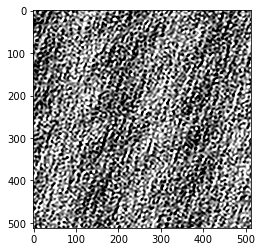

In [123]:
# create a very simple neural network with sine activations
from torch import nn, optim
from torch.nn import functional as F

def imshow(im):
    plt.imshow(im, vmin=-0.255, vmax=0.255, cmap='gray')

class Sine(nn.Module):
    '''
    A sinusoidal activation function.
    '''
    def forward(self, x):
        return torch.sin(x)

n_hidden = 200
activ_fn = Sine

model = nn.Sequential(
    nn.Linear(X.shape[1], n_hidden), activ_fn(),
    nn.Linear(n_hidden, n_hidden), activ_fn(),
    nn.Linear(n_hidden, Y.shape[1])
).cuda()

# generate an image using the initial model parameters
Y_pred = model(X - X_mean)
pred = (Y_pred + Y_mean).reshape(data.shape).detach().cpu().numpy()
imshow(pred)

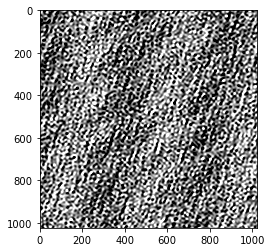

In [124]:
# super resolution
super_res = (1024, 1024)
X_super = (
    ndidx(torch.zeros(*super_res)).float() *
    torch.tensor(data.shape)[:-1].unsqueeze(0) /
    torch.tensor(super_res).unsqueeze(0)
).cuda()

Y_super = model.forward(X_super - X_mean) + Y_mean
pred = Y_super.reshape(super_res + (data.shape[-1],)).detach().cpu().numpy()
imshow(pred)

In [125]:
# fit the SIREN model to the real image
optimizer = optim.Adam(model.parameters(), lr=1e-5)

def pde_loss(y, x):
    dydx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    d2ydx2 = torch.autograd.grad(dydx, x, grad_outputs=torch.ones_like(dydx), create_graph=True)[0]
    pde = d2ydx2.sum(dim=1) #- y.sum(dim=1)
    return (pde**2).mean()

X.requires_grad = True

n_steps = 20000
for i in range(n_steps+1):
    Y_pred = model.forward(X - X_mean)
    loss = F.mse_loss(Y - Y_mean, Y_pred)# + pde_loss(Y_pred, X)
    if i % 1000 == 0:
        print(f'step = {i}, loss = {loss}')
    if i == n_steps:
        break
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


step = 0, loss = 0.056145079433918
step = 1000, loss = 0.00863594189286232
step = 2000, loss = 0.008105164393782616
step = 3000, loss = 0.007817956618964672
step = 4000, loss = 0.0074217598885297775
step = 5000, loss = 0.006763755343854427
step = 6000, loss = 0.005697824992239475
step = 7000, loss = 0.0044003380462527275
step = 8000, loss = 0.0032581710256636143
step = 9000, loss = 0.0024092993699014187
step = 10000, loss = 0.0018026612233370543
step = 11000, loss = 0.0013730843784287572
step = 12000, loss = 0.0010696826502680779
step = 13000, loss = 0.0008558728732168674
step = 14000, loss = 0.0007040154305286705
step = 15000, loss = 0.0005942240823060274
step = 16000, loss = 0.0005127543117851019
step = 17000, loss = 0.000450853374786675
step = 18000, loss = 0.0004026879323646426
step = 19000, loss = 0.00036456884117797017
step = 20000, loss = 0.0003336777735967189


(-0.31416047, 0.31480673)

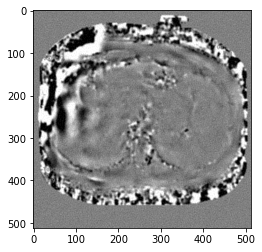

In [126]:
# generate an image using the trained SIREN model
Y_pred = model.forward(X - X_mean) + Y_mean
pred = Y_pred.reshape(data.shape).detach().cpu().numpy()
imshow(pred)
(pred.min(), pred.max())

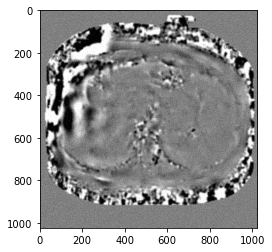

In [127]:
# super resolution
super_res = (1024, 1024)
X_super = (
    ndidx(torch.zeros(*super_res)).float() *
    torch.tensor(data.shape)[:-1].unsqueeze(0) /
    torch.tensor(super_res).unsqueeze(0)
).cuda()

Y_super = model.forward(X_super - X_mean) + Y_mean
pred = Y_super.reshape(super_res + (data.shape[-1],)).detach().cpu().numpy()
imshow(pred)

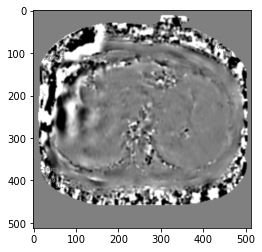

In [128]:
real = Y.reshape(data.shape).detach().cpu().numpy()
imshow(real)